In [1]:
import asyncio
import os
import pandas as pd
import numpy as np
from dotenv import load_dotenv
from alpaca.data.live import StockDataStream
from alpaca.trading.client import TradingClient
from alpaca.trading.requests import MarketOrderRequest
from alpaca.trading.enums import OrderSide, TimeInForce
from alpaca.data.enums import DataFeed
from alpaca.data.timeframe import TimeFrame
import matplotlib.pyplot as plt
from datetime import datetime
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest

# Load environment variables
load_dotenv()  # Load .env file

API_KEY = os.getenv("ALPACA_API_KEY")
API_SECRET = os.getenv("ALPACA_SECRET_KEY")

# Initialize TradingClient
Trading_Client = TradingClient(API_KEY, API_SECRET, paper=True)  # paper=True for paper trading
data_client = StockHistoricalDataClient(API_KEY, API_SECRET)

Fetching 1-minute historical data for MSFT...
Running backtest...

--- Trade Summary ---
Total Trades: 248
Winning %: 44.35%
Total PnL: $-41.05
Average PnL: $-0.17


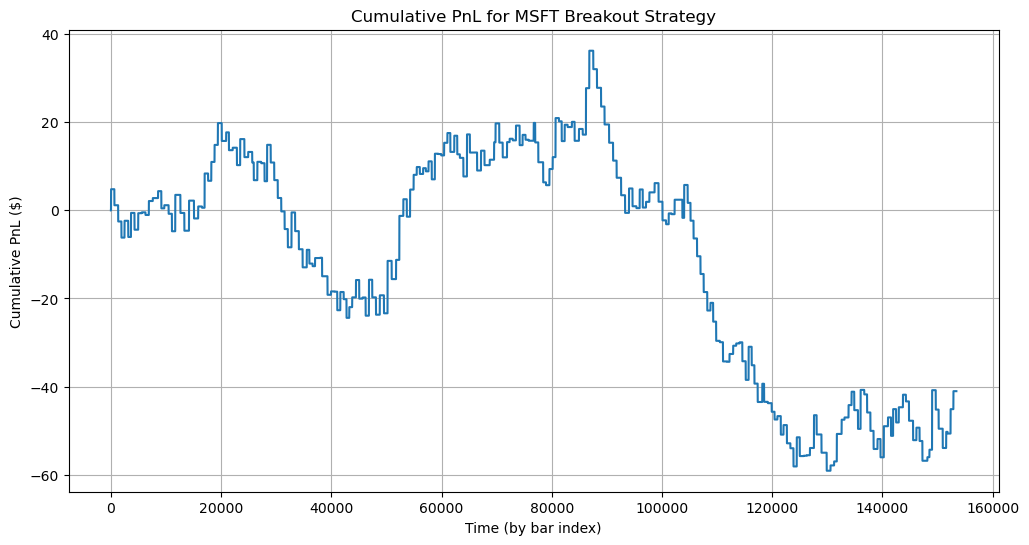

In [37]:
# --- Parameters ---
THRESHOLD = 0.5  # % move from open to trigger trade
STOP_LOSS_PCT = 1.0  # % stop loss
TAKE_PROFIT_PCT = 3.0  # % take profit
SYMBOL = "MSFT"
COMMISSION_PER_TRADE = 0  # Set to 0 if not considering costs for this version

# --- Fetch historical data ---
# Fetches minute-level data required for this intraday strategy
print(f"Fetching 1-minute historical data for {SYMBOL}...")
request_params = StockBarsRequest(
    symbol_or_symbols=[SYMBOL],
    timeframe=TimeFrame.Minute,
    start=datetime(2024, 1, 1),
    end=datetime(2024, 12, 31),
    adjustment='all'
)
bars = data_client.get_stock_bars(request_params)

# --- Handle DataFrame based on index type ---
df = bars.df
if isinstance(df.index, pd.MultiIndex):
    df = df.xs(SYMBOL, level='symbol').reset_index()
else:
    df = df.reset_index()

# --- Implement threshold strategy ---
def threshold_strategy(data, threshold, stop_loss_pct, take_profit_pct):
    data = data.copy()
    data['date'] = pd.to_datetime(data['timestamp']).dt.date
    data['Position'] = "None"
    data['PnL'] = 0.0

    # FIX: Initialize the list that will be returned
    trades_list = []

    grouped = data.groupby('date')

    for date, group in grouped:
        if group.empty:
            continue

        day_open = group.iloc[0]['open']
        threshold_up = day_open * (1 + threshold / 100)
        threshold_down = day_open * (1 - threshold / 100)

        trade_triggered = False

        for i in range(len(group)):
            current = group.iloc[i]
            idx = current.name # Use .name to get the index label safely

            # --- Long Entry ---
            if not trade_triggered and current['high'] >= threshold_up:
                entry_price = threshold_up
                data.loc[idx, 'Position'] = 'Long'
                trade_triggered = True

                sl_long = entry_price * (1 - stop_loss_pct / 100)
                tp_long = entry_price * (1 + take_profit_pct / 100)
                exit_price = 0
                pnl = 0

                for j in range(i + 1, len(group)):
                    forward = group.iloc[j]
                    if forward['low'] <= sl_long:
                        exit_price = sl_long
                        break
                    elif forward['high'] >= tp_long:
                        exit_price = tp_long
                        break
                else:
                    exit_price = group.iloc[-1]['close']

                pnl = (exit_price - entry_price) - COMMISSION_PER_TRADE
                data.loc[idx, 'PnL'] = pnl
                trades_list.append({'Date': date, 'Entry': entry_price, 'Exit': exit_price, 'PnL': pnl, 'Position': 'Long'})
                break

            # --- Short Entry ---
            elif not trade_triggered and current['low'] <= threshold_down:
                entry_price = threshold_down
                data.loc[idx, 'Position'] = 'Short'
                trade_triggered = True

                sl_short = entry_price * (1 + stop_loss_pct / 100)
                tp_short = entry_price * (1 - take_profit_pct / 100)
                exit_price = 0
                pnl = 0

                for j in range(i + 1, len(group)):
                    forward = group.iloc[j]
                    if forward['high'] >= sl_short:
                        exit_price = sl_short
                        break
                    elif forward['low'] <= tp_short:
                        exit_price = tp_short
                        break
                else:
                    exit_price = group.iloc[-1]['close']

                pnl = (entry_price - exit_price) - COMMISSION_PER_TRADE
                data.loc[idx, 'PnL'] = pnl
                trades_list.append({'Date': date, 'Entry': entry_price, 'Exit': exit_price, 'PnL': pnl, 'Position': 'Short'})
                break

    # FIX: Return both the DataFrame and the list of trades
    return data, trades_list


# --- Run strategy ---
print("Running backtest...")
results_df, trades = threshold_strategy(df, THRESHOLD, STOP_LOSS_PCT, TAKE_PROFIT_PCT)


# --- Metrics and Visualization ---
print("\n--- Trade Summary ---")
trades_df = pd.DataFrame(trades)
# Calculate cumulative PnL on the main results dataframe
results_df['Cumulative_PnL'] = results_df['PnL'].cumsum()

if not trades_df.empty:
    print(f"Total Trades: {len(trades_df)}")
    winning_trades = (trades_df['PnL'] > 0).sum()
    win_rate = (winning_trades / len(trades_df)) * 100 if len(trades_df) > 0 else 0
    print(f"Winning %: {win_rate:.2f}%")
    # Note: PnL here is the raw price change. To get $, you'd multiply by number of shares.
    print(f"Total PnL: ${trades_df['PnL'].sum():.2f}")
    print(f"Average PnL: ${trades_df['PnL'].mean():.2f}")

    # --- Plot ---
    plt.figure(figsize=(12, 6))
    # Plot from the main dataframe to show account growth over time
    results_df['Cumulative_PnL'].plot(title=f'Cumulative PnL for {SYMBOL} Breakout Strategy')
    plt.xlabel("Time (by bar index)")
    plt.ylabel("Cumulative PnL ($)")
    plt.grid(True)
    plt.show()
else:
    print("No trades were executed during the backtest period.")